---

# Model with standardized price values

#### setup

In [35]:
# import modules
# basic
import pandas as pd
import numpy as np
import datetime as dt

# SQL
from dotenv import load_dotenv
import os
from sqlalchemy import create_engine

# sklearn
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor

# Stationary Tests
from statsmodels.tsa.stattools import adfuller,kpss
from statsmodels.tsa.arima.model import ARIMA


# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

NSEED = 42

In [2]:
# set graphic parameters to have unified plot appearance
sns.set_style(
    style='darkgrid', 
    rc={'axes.facecolor': 'white', 'grid.color': '.8'}
)
NF_ORANGE = '#ff5a36'
NF_BLUE = '#163251'
cmaps_hex = ['#193251','#FF5A36','#696969', '#7589A2','#FF5A36', '#DB6668']
sns.set_palette(palette=cmaps_hex)
sns_c = sns.color_palette(palette=cmaps_hex)
%matplotlib inline
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['figure.dpi'] = 300

---

#### load data

In [25]:
# Load environment variables from .env file
load_dotenv()

# Get database connection parameters from environment variables
db_name = os.getenv('DB_NAME')
db_user = os.getenv('DB_USER')
db_password = os.getenv('DB_PASSWORD')
db_host = os.getenv('DB_HOST')
db_port = os.getenv('DB_PORT')

# Create the database URL
db_url = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"

# Create an engine
engine = create_engine(db_url)

# Define your query -> set your table name here
query = 'SELECT * FROM "03_gold"."fact_electricity_market_germany"'

# Execute the query and load the data into a pandas DataFrame
df_modelling = pd.read_sql(query, engine)

# Display the DataFrame
df_modelling.head()

,timestamp,temperature_2m,relative_humidity_2m,apparent_temperature,precipitation,cloud_cover,wind_speed_10m,wind_direction_10m,direct_radiation,diffuse_radiation,...,hydro_pumped_storage_consumption,load_incl_self_consumption,cross_border_electricity_trading,residual_load,renewable_share_of_generation,renewable_share_of_load,total_renewable_production,total_production,total_consumption,price_eur_mwh
0,2018-09-30 22:00:00+00:00,8.991667,78.833333,6.512500,0.154167,42.750000,9.825000,246.375000,0.0,0.0,...,-15476.0,176047.6,-18224.4,152075.9,23.800,29.450,48720.1,216330.2,157823.2,51.41
1,2018-09-30 23:00:00+00:00,8.662500,80.000000,6.150000,0.133333,48.666667,9.908333,252.583333,0.0,0.0,...,-19584.4,179642.8,-12223.6,154628.3,24.125,29.425,49741.5,217749.7,167419.2,47.38
2,2018-10-01 00:00:00+00:00,8.525000,81.041667,5.970833,0.125000,55.666667,10.083333,262.291667,0.0,0.0,...,-21551.4,186356.6,-8967.6,158032.7,24.900,30.175,53081.7,224055.9,177389.0,47.59
3,2018-10-01 01:00:00+00:00,8.108333,82.166667,5.629167,0.391667,57.291667,9.404167,265.541667,0.0,0.0,...,-8047.7,205140.1,-16874.4,173895.4,24.725,28.800,56192.8,237892.2,188265.7,51.61
4,2018-10-01 02:00:00+00:00,7.929167,82.458333,5.420833,0.387500,62.625000,9.512500,267.166667,0.0,0.0,...,-2994.0,245378.4,-4541.2,207504.4,24.975,26.900,64654.9,262419.4,240837.2,69.13


---

#### outlier treatment - if necessary

In [26]:
################ OUTLIER TREATMENT #######################
# Replace outliers with NAs
df_modelling.loc[df_modelling['price_eur_mwh'] < -200, 'price_eur_mwh'] = np.nan

# Replace NAs by imputation
df_modelling['price_eur_mwh'] = df_modelling['price_eur_mwh'].interpolate()

---

#### create lagged price feature

In [27]:
# Create lag feature for the same hour on the previous day
df_modelling['price_lag24'] = df_modelling['price_eur_mwh'].shift(24)

---

#### add rolling mean / rolling variance / z-score

In [28]:
# Step 1: Create rolling mean for the last seven days (7*24 hours)
df_modelling['rolling_mean_7d'] = df_modelling['price_eur_mwh'].rolling(window=7*24).mean()

# Step 2: Create rolling standard deviation for the last seven days
df_modelling['rolling_std_7d'] = df_modelling['price_eur_mwh'].rolling(window=7*24).std()

# Step 3: Create the variable that subtracts the actual price from the rolling mean and divides by the rolling std
df_modelling['z_score'] = (df_modelling['price_eur_mwh'] - df_modelling['rolling_mean_7d']) / df_modelling['rolling_std_7d']

# Step 4: Create three copies of this variable
df_modelling['z_score_capped_5'] = df_modelling['z_score'].clip(-5, 5)

df_modelling['z_score_na_5'] = df_modelling['z_score'].where(df_modelling['z_score'].between(-5, 5))
df_modelling['z_score_na_5'] = df_modelling['z_score_na_5'].interpolate()

df_modelling['z_score_na_3'] = df_modelling['z_score'].where(df_modelling['z_score'].between(-3, 3))
df_modelling['z_score_na_3'] = df_modelling['z_score_na_3'].interpolate()

---

#### drop missing values introduced to lagged features 

In [29]:
# Drop missing values introduced due to the lag
df_modelling.dropna(inplace=True)

---

#### change datetime to numeric for model purposes

In [30]:
# Change datetime to numeric
df_modelling['timestamp']=df_modelling['timestamp'].map(dt.datetime.toordinal)

---

#### plot rolling mean and z-score(s)

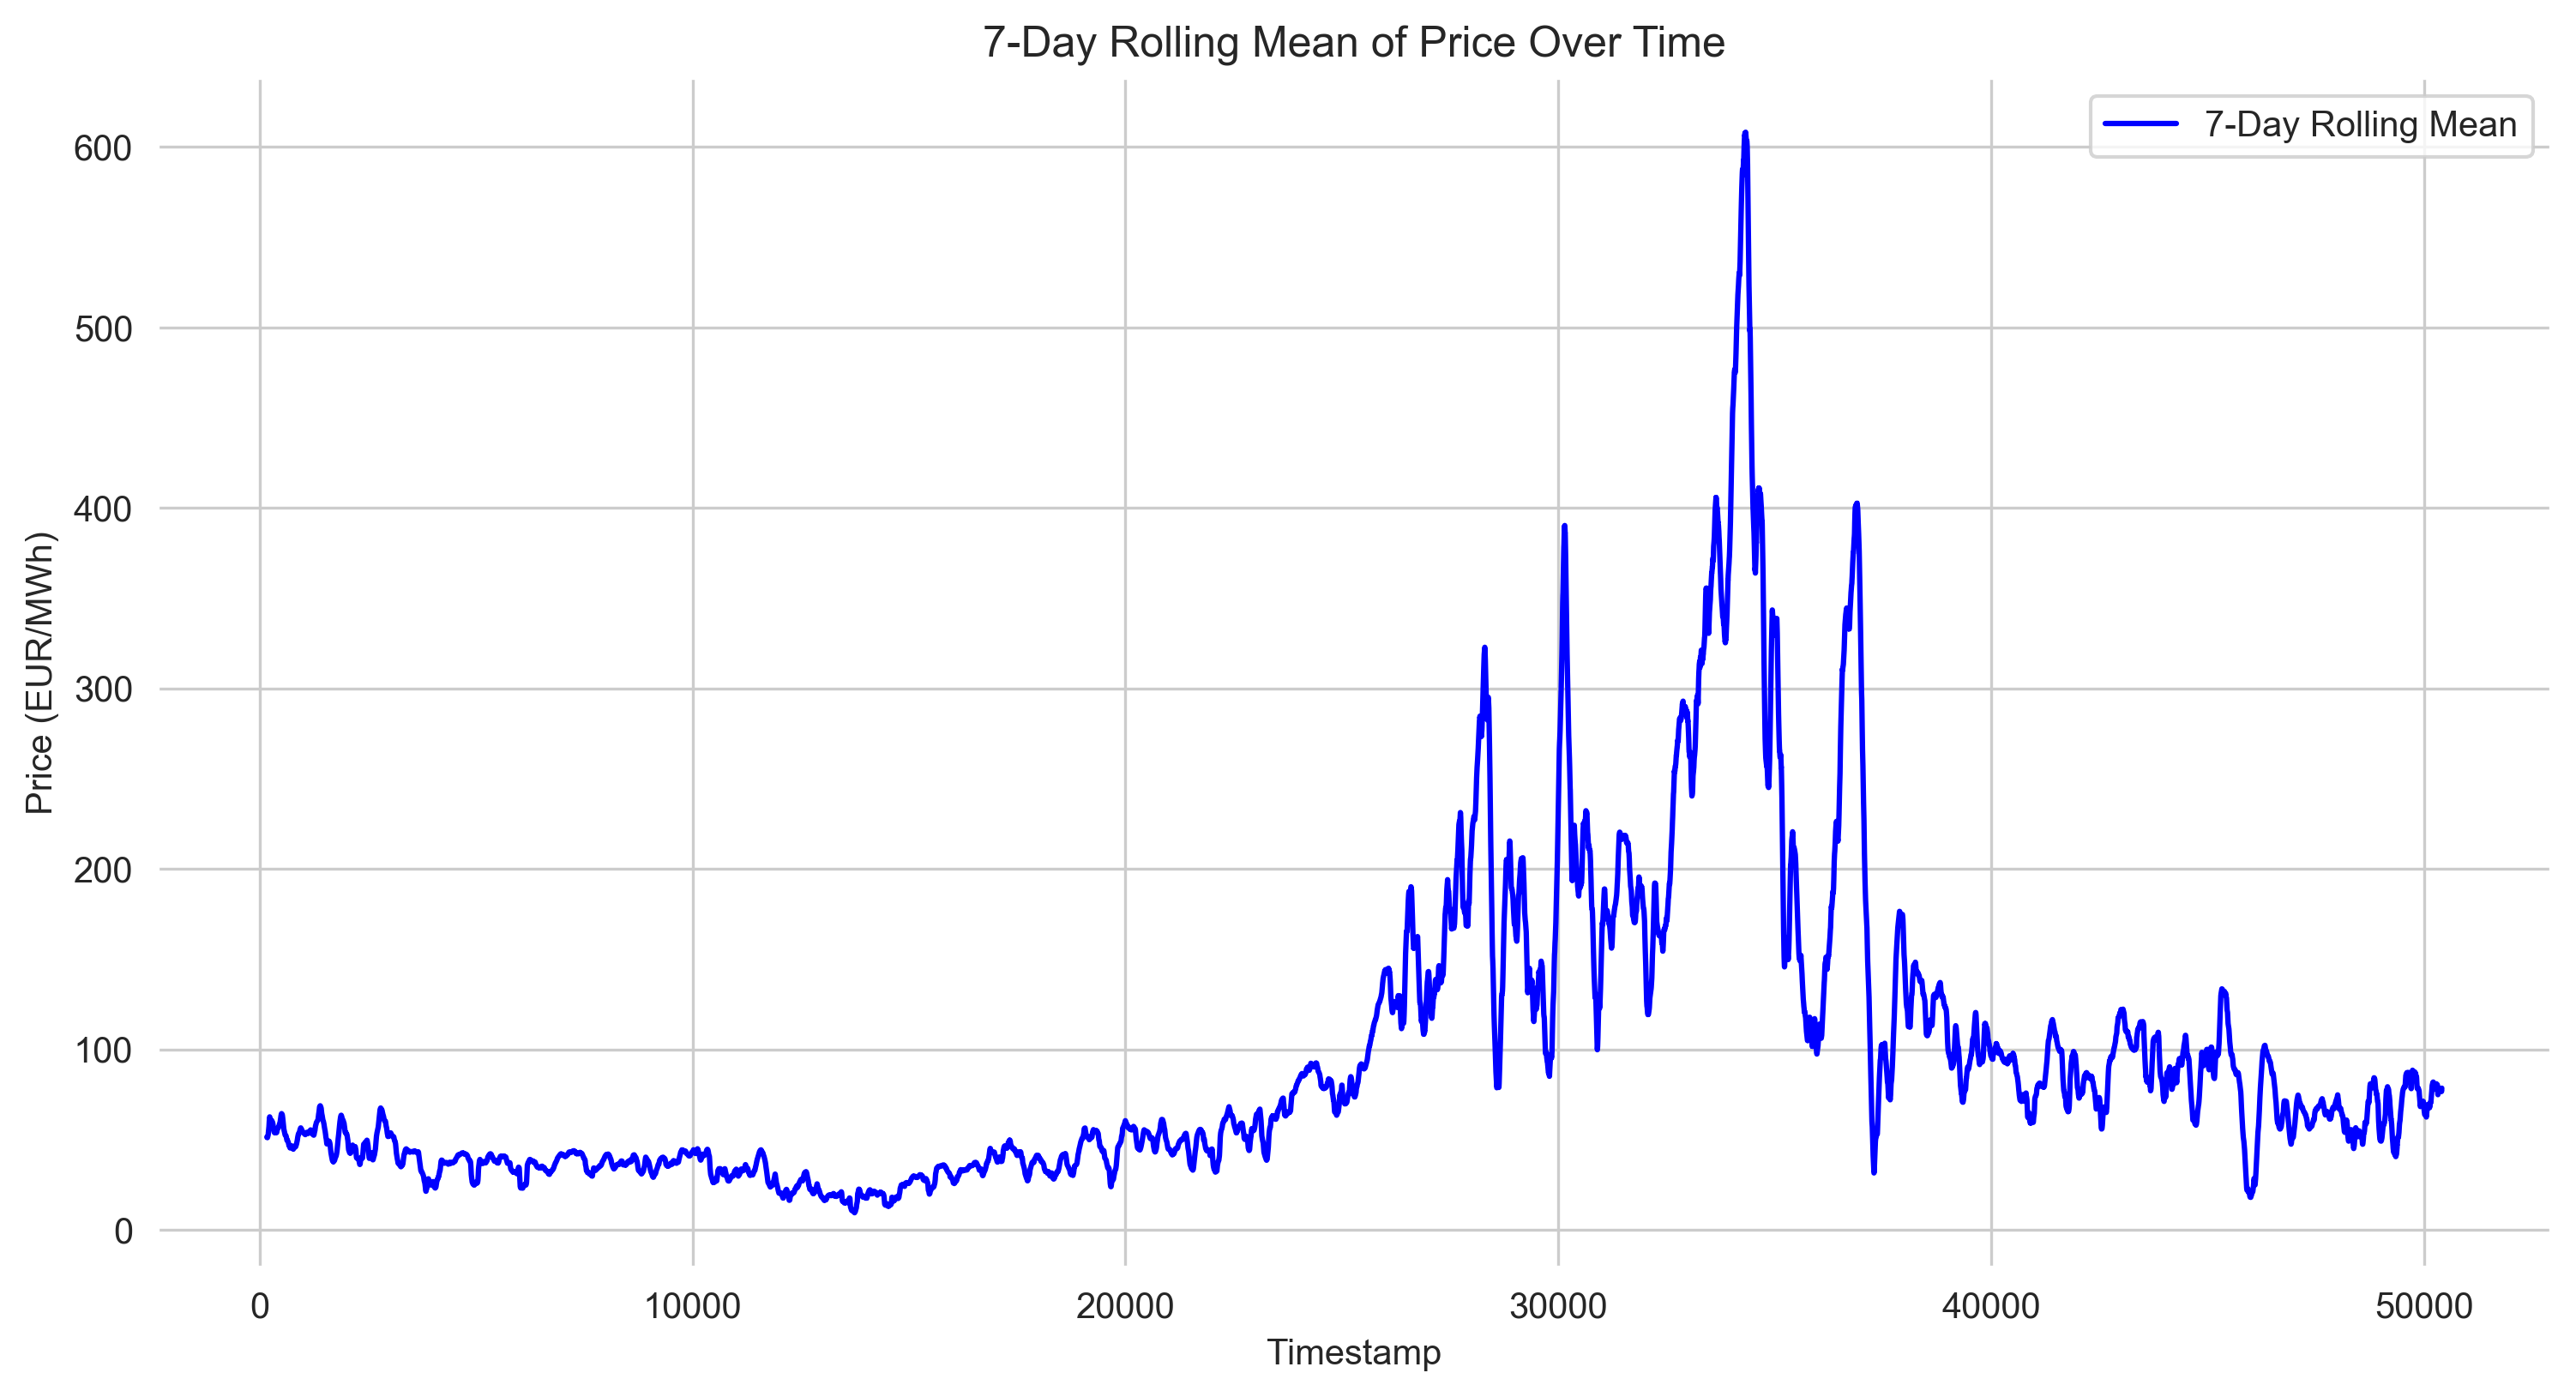

In [31]:
plt.plot(df_modelling.index, df_modelling['rolling_mean_7d'], label='7-Day Rolling Mean', color='blue')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('Price (EUR/MWh)')
plt.title('7-Day Rolling Mean of Price Over Time')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

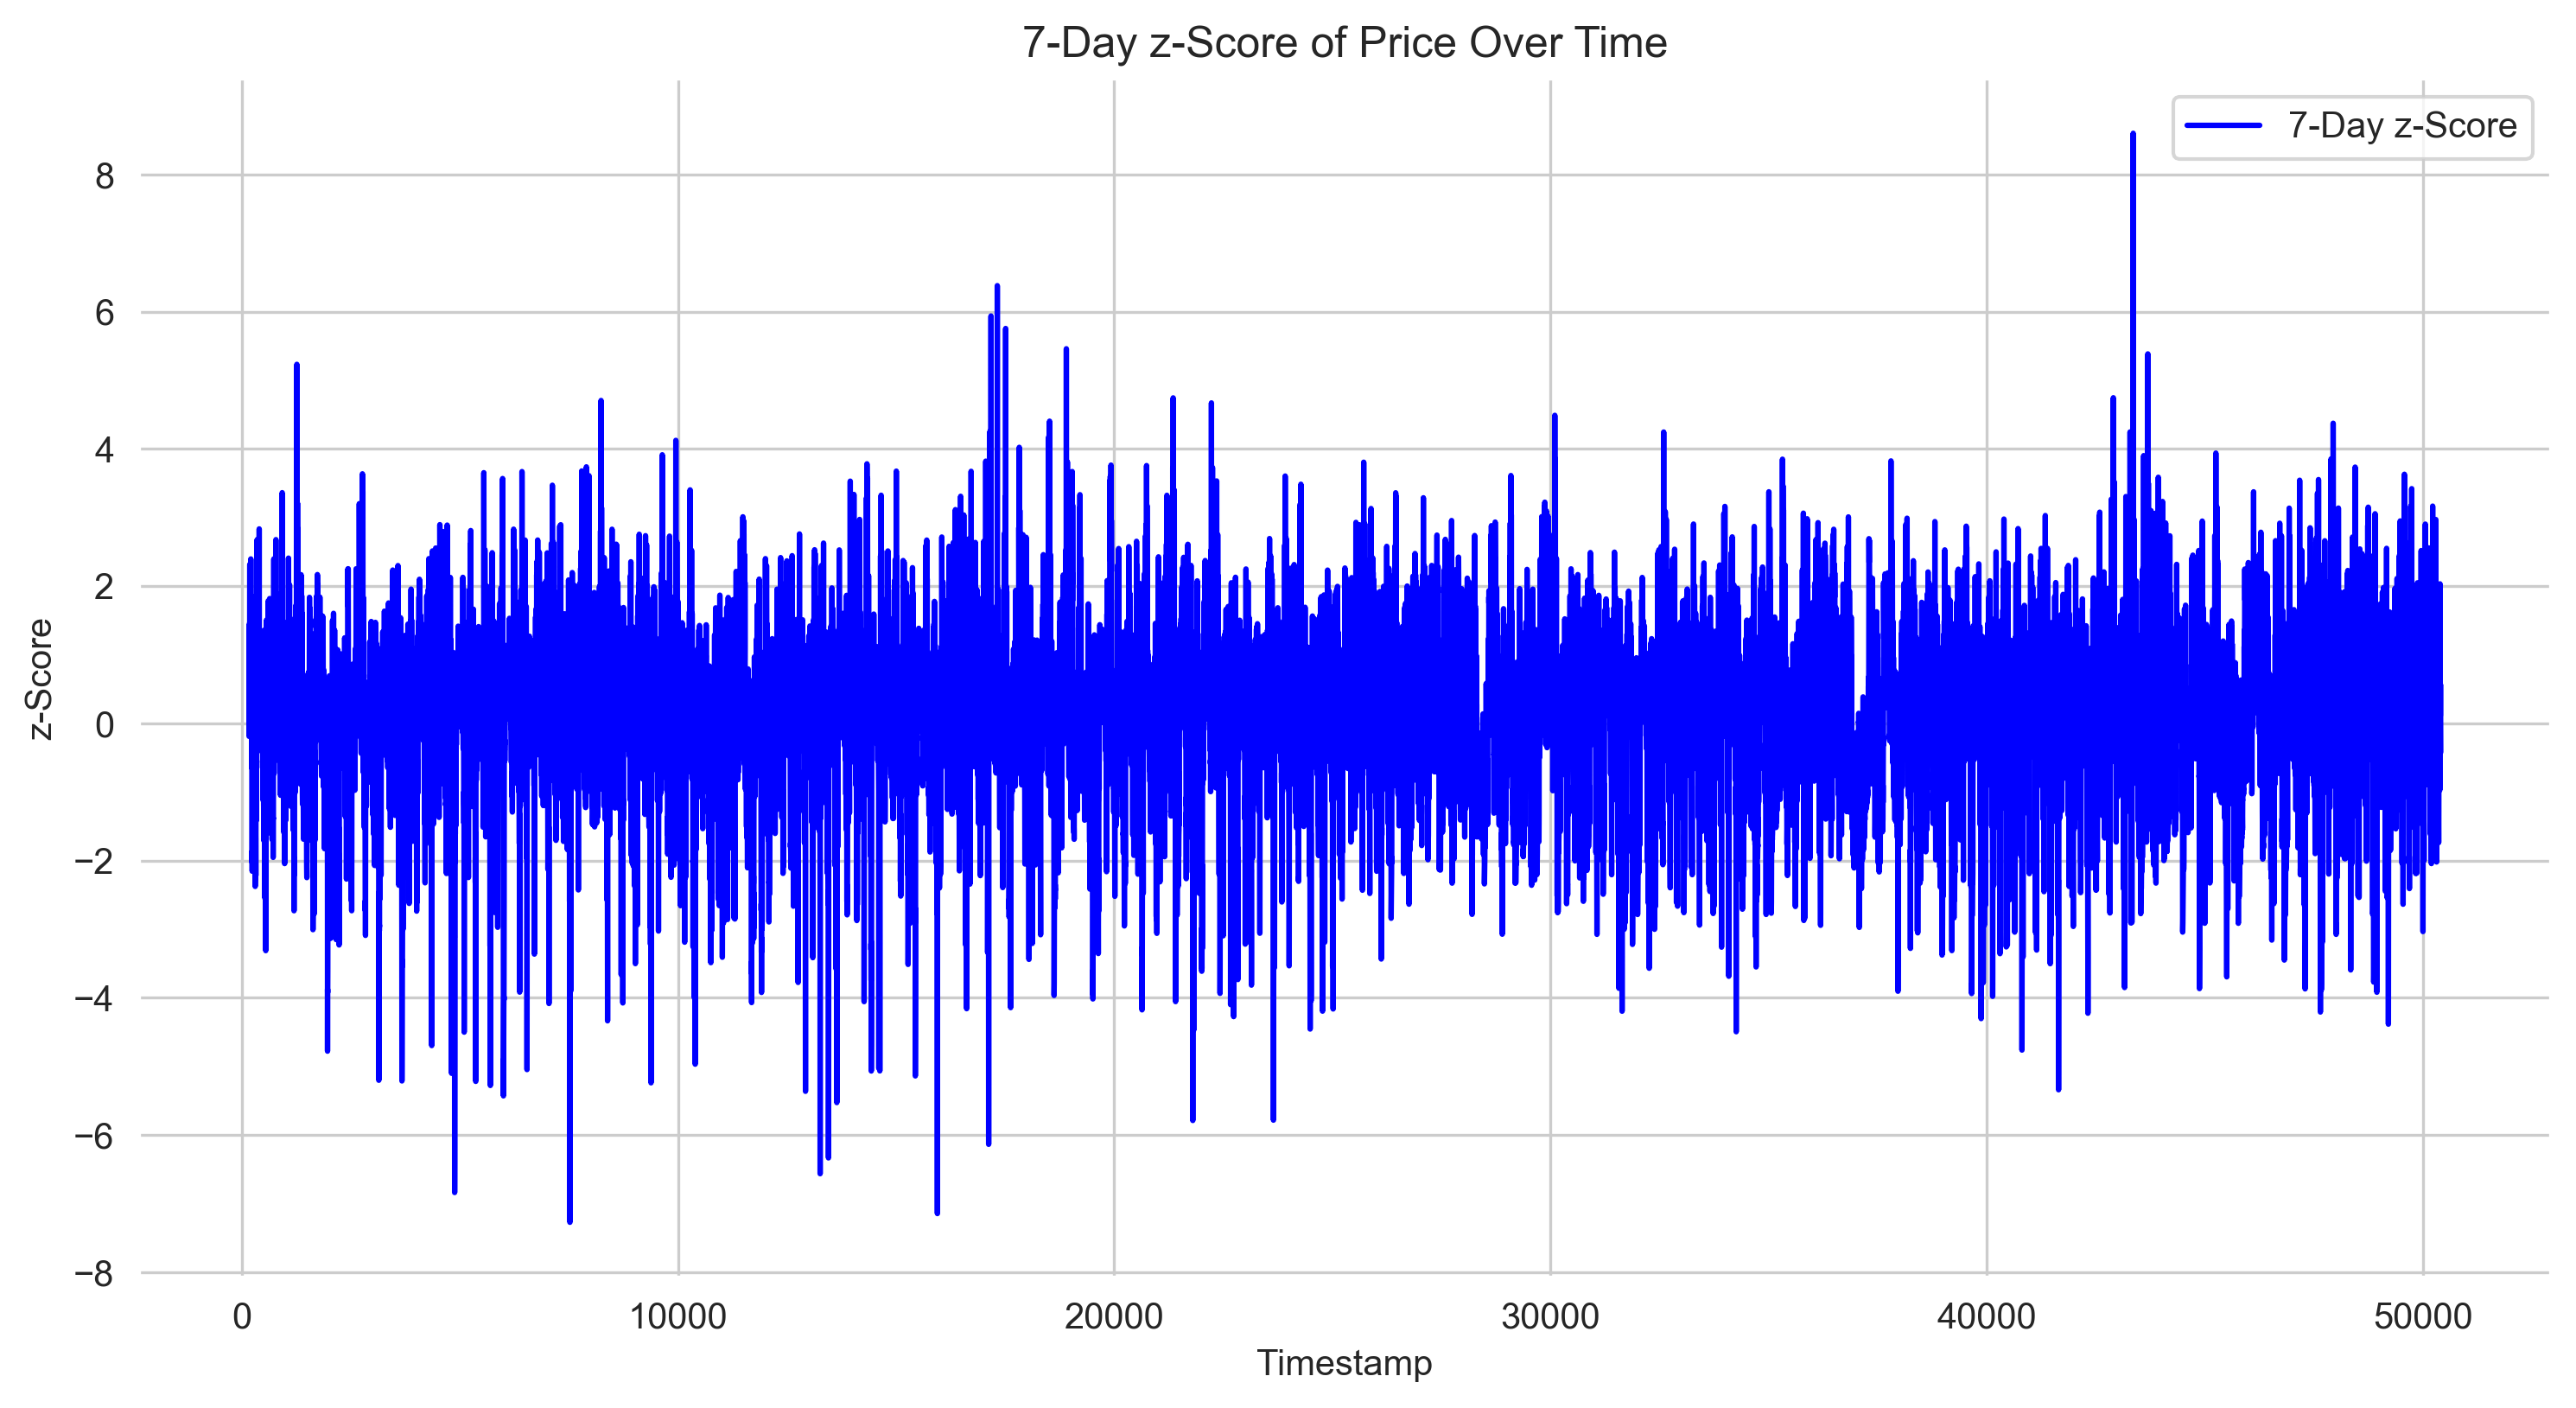

In [32]:
plt.plot(df_modelling.index, df_modelling['z_score'], label='7-Day z-Score', color='blue')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('z-Score')
plt.title('7-Day z-Score of Price Over Time')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

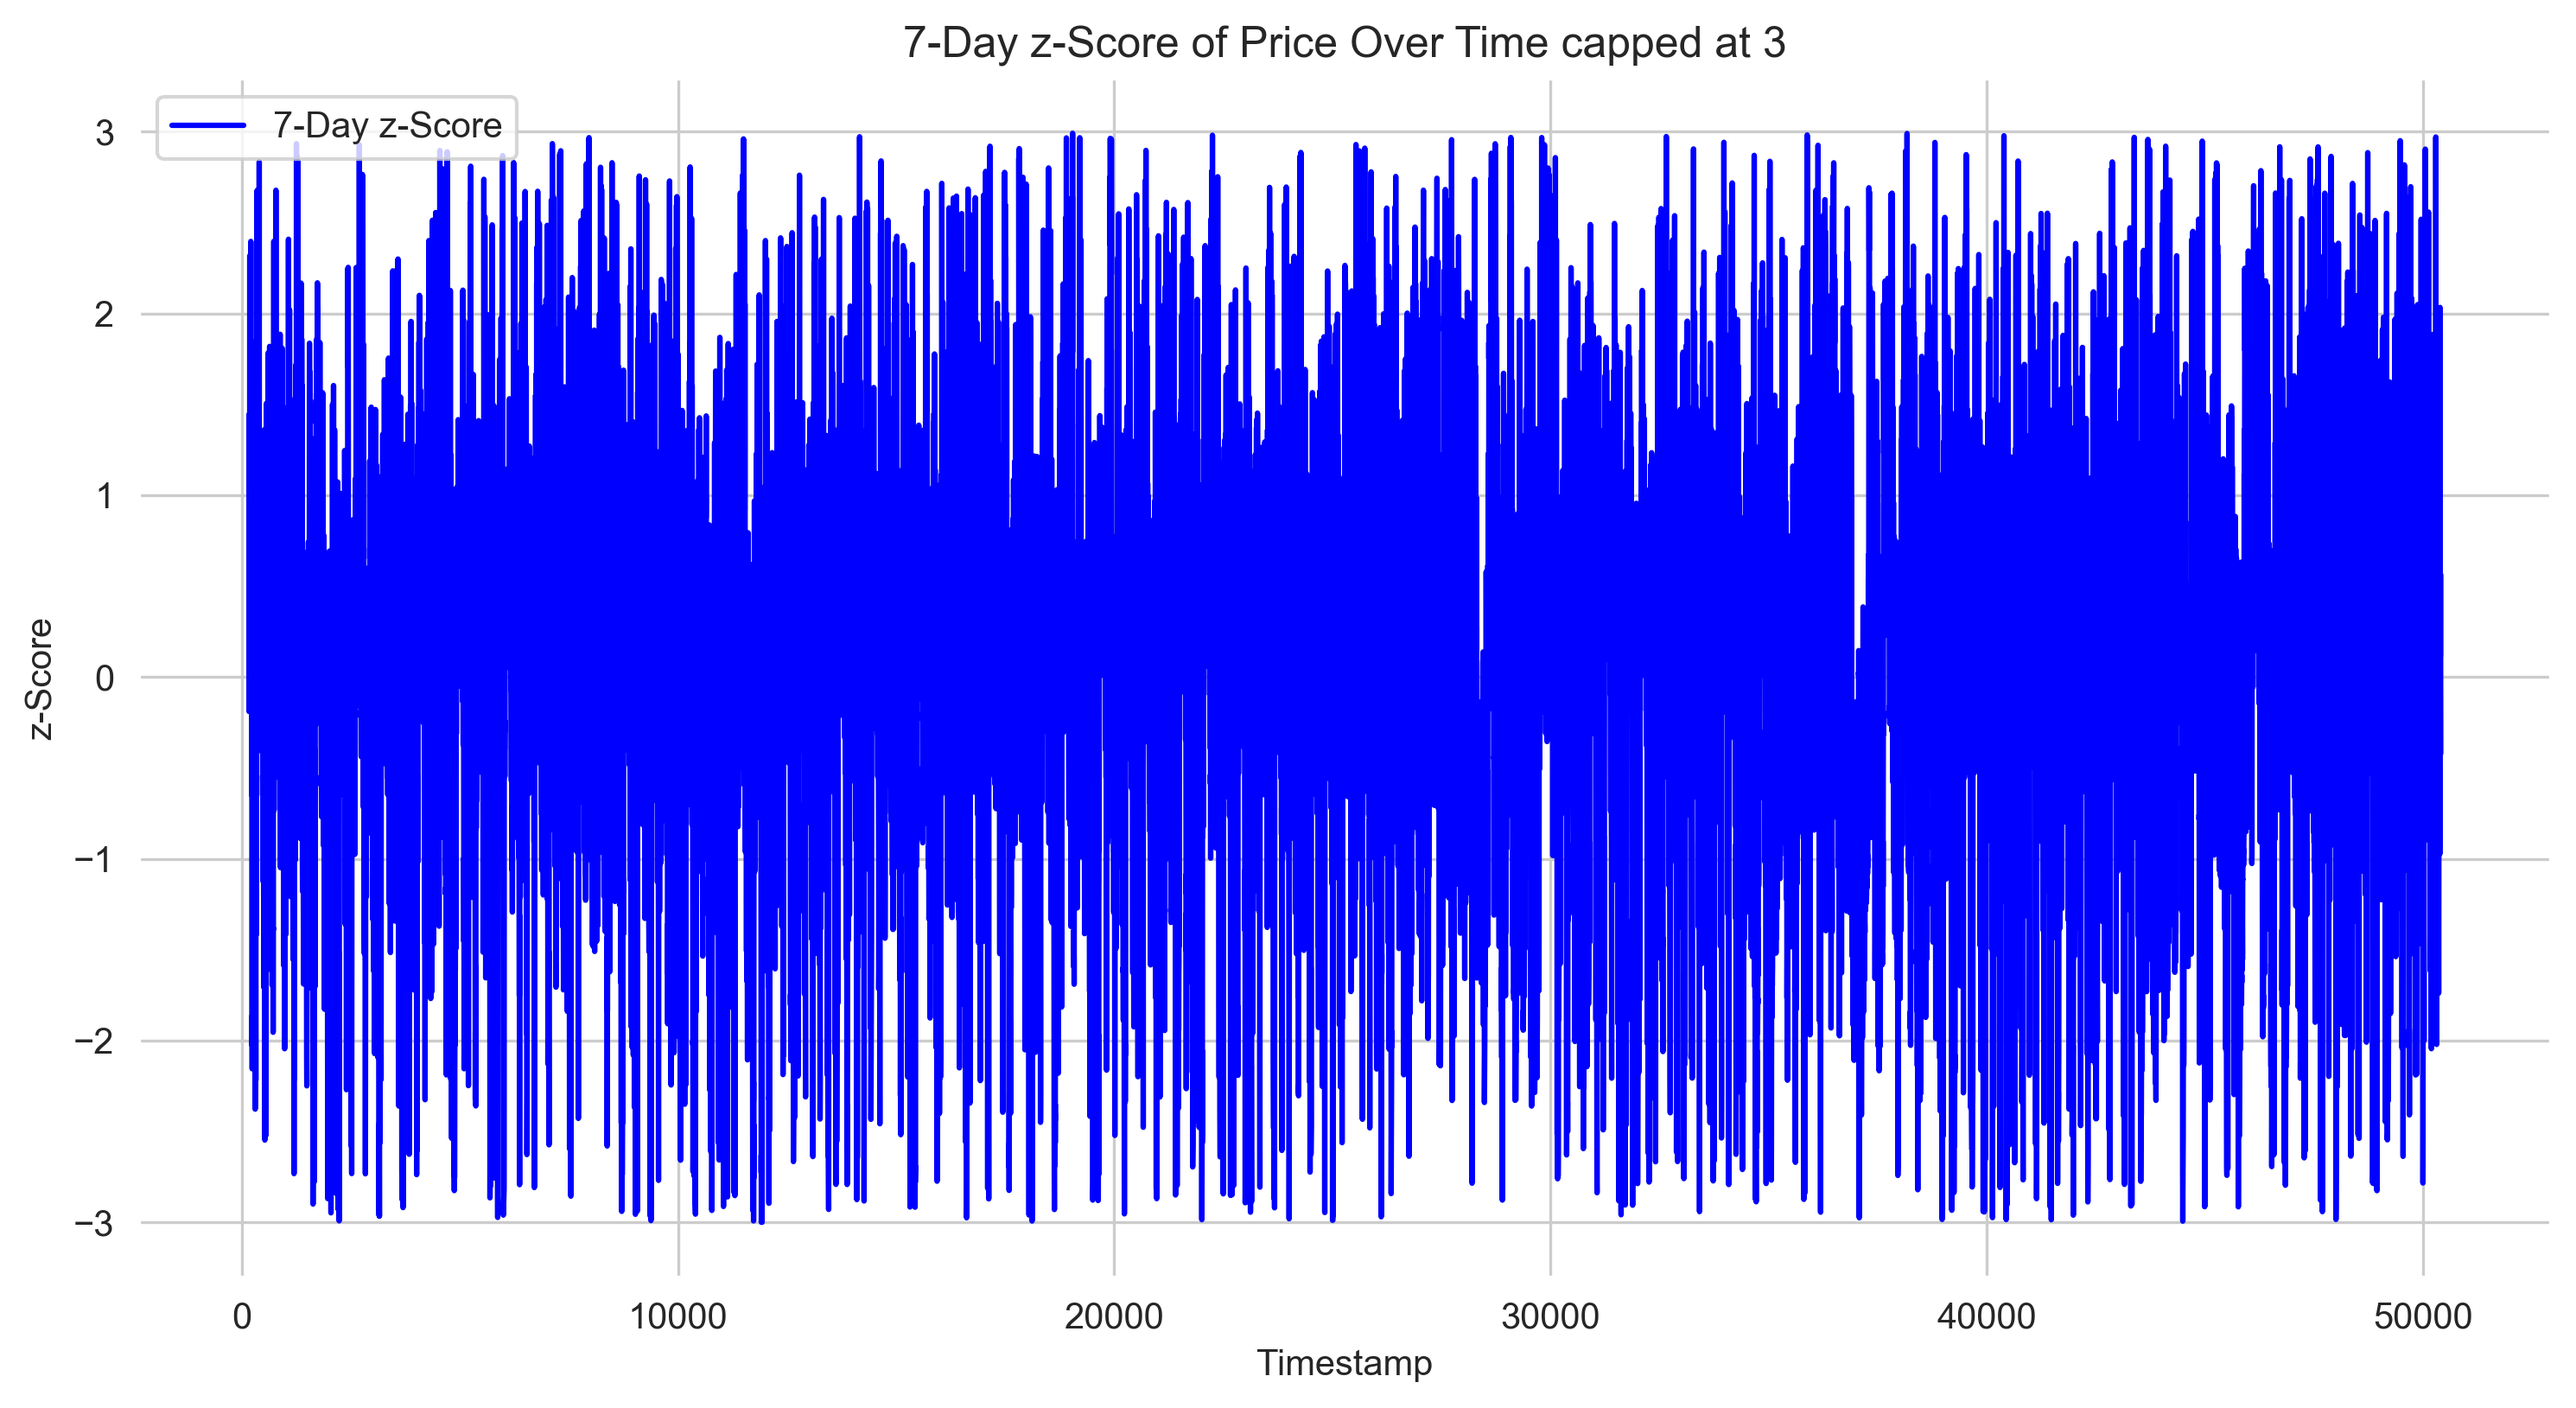

In [33]:
plt.plot(df_modelling.index, df_modelling['z_score_na_3'], label='7-Day z-Score', color='blue')

# Adding labels and title
plt.xlabel('Timestamp')
plt.ylabel('z-Score')
plt.title('7-Day z-Score of Price Over Time capped at 3')
plt.legend()

# Displaying the plot
plt.grid(True)
plt.show()

---
---
#### create splits for expanding window

In [36]:
# create splits for expanding window crossvalidation
# Parameters
n_splits = 23 # our data has 23 quarters = (len(X) / 2190)
train_increment = 2190  # Number of hours in a quarter year
test_size = 72 # we currently want to predict for 72 hours. Can be adjusted.

class CustomTimeSeriesSplit:
    def __init__(self, n_splits, train_increment, test_size):
        self.n_splits = n_splits
        self.train_increment = train_increment
        self.test_size = test_size

    def split(self, X):
        n_samples = len(X)
        indices = np.arange(n_samples)
        splits = []
        
        for i in range(self.n_splits):
            train_end = (i + 1) * self.train_increment
            test_end = train_end + self.test_size
            
            if test_end > n_samples:
                break

            train_index = indices[:train_end]
            test_index = indices[train_end:test_end]
            splits.append((train_index, test_index))
        
        return splits
    

# Get the custom splits
custom_splitter = CustomTimeSeriesSplit(n_splits=n_splits, train_increment=train_increment, test_size=test_size)
splits = custom_splitter.split(X)

---
#### Create model function

In [37]:
def evaluate_time_series_model(X, y, model_class, model_params=None, n_splits=n_splits):
    """
    Evaluate a time series model with time series cross-validation.

    Parameters:
    - X: pd.DataFrame, feature matrix
    - y: pd.Series, target variable
    - model_class: Class, model class to be used (e.g., LinearRegression)
    - model_params: dict, hyperparameters for the model (default is None)
    - n_splits: int, number of splits for time series cross-validation

    Returns:
    - mse_scores: list of MSE scores for each split
    - average_mse: average MSE across all splits
    - mse_score_sum: DataFrame containing MSE scores for each split and type (Train/Test)
    - plot_data: list of dictionaries containing data for plotting
    """
    if model_params is None:
        model_params = {}

    mse_scores = []
    mse_score_graph = []
    plot_data = []

    for i, (train_index, test_index) in enumerate(splits):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]

        # For non-ARIMA models
        if model_class != ARIMA:
            scaler = StandardScaler()
            X_train_scaled = scaler.fit_transform(X_train)
            X_test_scaled = scaler.transform(X_test)

            model = model_class(**model_params)
            model.fit(X_train_scaled, y_train)
            
            y_pred_train = model.predict(X_train_scaled)
            y_pred_test = model.predict(X_test_scaled)
        
        # For ARIMA models
        else:
            model = ARIMA(y_train, **model_params)
            model_fit = model.fit()
            
            y_pred_train = model_fit.fittedvalues
            y_pred_test = model_fit.forecast(steps=len(y_test))
        
        mse_train = mean_squared_error(y_train, y_pred_train)
        mse_test = mean_squared_error(y_test, y_pred_test)
        
        mse_scores.append(mse_test)
        
        print(f"Split {i+1}:")
        print(f"MSE (train): {mse_train}, MSE (test): {mse_test}")
        
        # Prepare data for seaborn
        mse_comparison = pd.DataFrame({
            'Type': ['Train', 'Test'],
            'MSE': [mse_train, mse_test],
            'split': [i+1, i+1]
        })
        mse_score_graph.append(mse_comparison)
        
        # Store data for plotting later
        plot_data.append({
            'split': i+1,
            'y_train': y_train,
            'y_pred_train': y_pred_train,
            'y_test': y_test,
            'y_pred_test': y_pred_test
        })

    # Optional: Average MSE across all splits for overall evaluation
    average_mse = sum(mse_scores) / len(mse_scores)
    print(f"Average Test MSE across all splits: {average_mse}")

    mse_score_sum = pd.concat(mse_score_graph, axis=0)
    mse_score_sum['split'] = mse_score_sum['split'].astype(int)

    return mse_scores, average_mse, mse_score_sum, plot_data

---

#### create plot function

In [38]:
def plot_time_series(plot_data, mse_score_sum, model_name = '', only_bar = True):
    """
    Plot the time series data stored in plot_data.

    Parameters:
    - plot_data: list of dictionaries containing data for plotting
    - mse_score_sum: DataFrame containing MSE scores for each split and type (Train/Test)
    - only_bar: if False, Time Series Plots will created for each split. Default = True.
    """

    if only_bar == False:
        for data in plot_data:
            split = data['split']
            y_train = data['y_train']
            y_pred_train = data['y_pred_train']
            y_test = data['y_test']
            y_pred_test = data['y_pred_test']

            # Plotting Full Time Series
            plt.figure()
            sns.lineplot(x=y_train.index, y=y_train, label='Actual train')
            sns.lineplot(x=y_train.index, y=y_pred_train, label='Predicted train', linestyle='--')
            sns.lineplot(x=y_test.index, y=y_test, label='Actual test')
            sns.lineplot(x=y_test.index, y=y_pred_test, label='Predicted test', linestyle='--')
            plt.title(f'Actual vs Predicted for Split {split}')
            plt.xlabel('Time')
            plt.ylabel('Target')
            plt.legend()
            plt.show()
            
            # Plotting Zoomed Time Series
            plt.figure()
            sns.lineplot(x=y_train.index[-168:], y=y_train[-168:], label='Actual train')
            sns.lineplot(x=y_train.index[-168:], y=y_pred_train[-168:], label='Predicted train', linestyle='--')
            sns.lineplot(x=y_test.index, y=y_test, label='Actual test')
            sns.lineplot(x=y_test.index, y=y_pred_test, label='Predicted test', linestyle='--')
            plt.title(f'Zoomed: Actual vs Predicted for Split {split}')
            plt.xlabel('Time')
            plt.ylabel('Target')
            plt.legend()
            plt.show()

    # Plot using seaborn
    if model_name != '':
        model_name = f'{model_name}: '
    plt.figure()
    sns.barplot(x='split', y='MSE', hue='Type', data=mse_score_sum)
    plt.title(f'{model_name}Comparison of MSE for Training and Test Sets')
    plt.ylabel('Mean Squared Error')
    plt.xlabel('Split')
    plt.show()

---
---
---
## Modeling

In [39]:
# Use only the default features to predict the z-standardized price
X = df_modelling.drop(columns=['z_score', 'price_eur_mwh', 'rolling_mean_7d', 'rolling_std_7d', 'z_score_capped_5', 'z_score_na_5', 'z_score_na_3'])
y = df_modelling['z_score']

---

#### ExtraTreesRegressor

Split 1:
MSE (train): 2.2565140103950553e-30, MSE (test): 0.2441226517319676
Split 2:
MSE (train): 2.3758234825951822e-30, MSE (test): 0.175764299752532
Split 3:
MSE (train): 2.4267129366730505e-30, MSE (test): 0.4432720816424577
Split 4:
MSE (train): 2.356998038941953e-30, MSE (test): 0.5342668646892194
Split 5:
MSE (train): 2.2952689889920058e-30, MSE (test): 0.3125761674996571
Split 6:
MSE (train): 2.276571477418335e-30, MSE (test): 0.1424161881764836
Split 7:
MSE (train): 2.316846405704438e-30, MSE (test): 0.18829617835601287
Split 8:
MSE (train): 2.33275649663287e-30, MSE (test): 0.1583175164221763
Split 9:
MSE (train): 2.3228335745847867e-30, MSE (test): 0.7734248620966601
Split 10:
MSE (train): 2.3487884604998934e-30, MSE (test): 0.642541294773578
Split 11:
MSE (train): 2.3521358335700174e-30, MSE (test): 0.33837380445009174
Split 12:
MSE (train): 7.312400124725873e-23, MSE (test): 0.4608163625268625
Split 13:
MSE (train): 2.341360715533303e-30, MSE (test): 0.9472270266165835
Sp

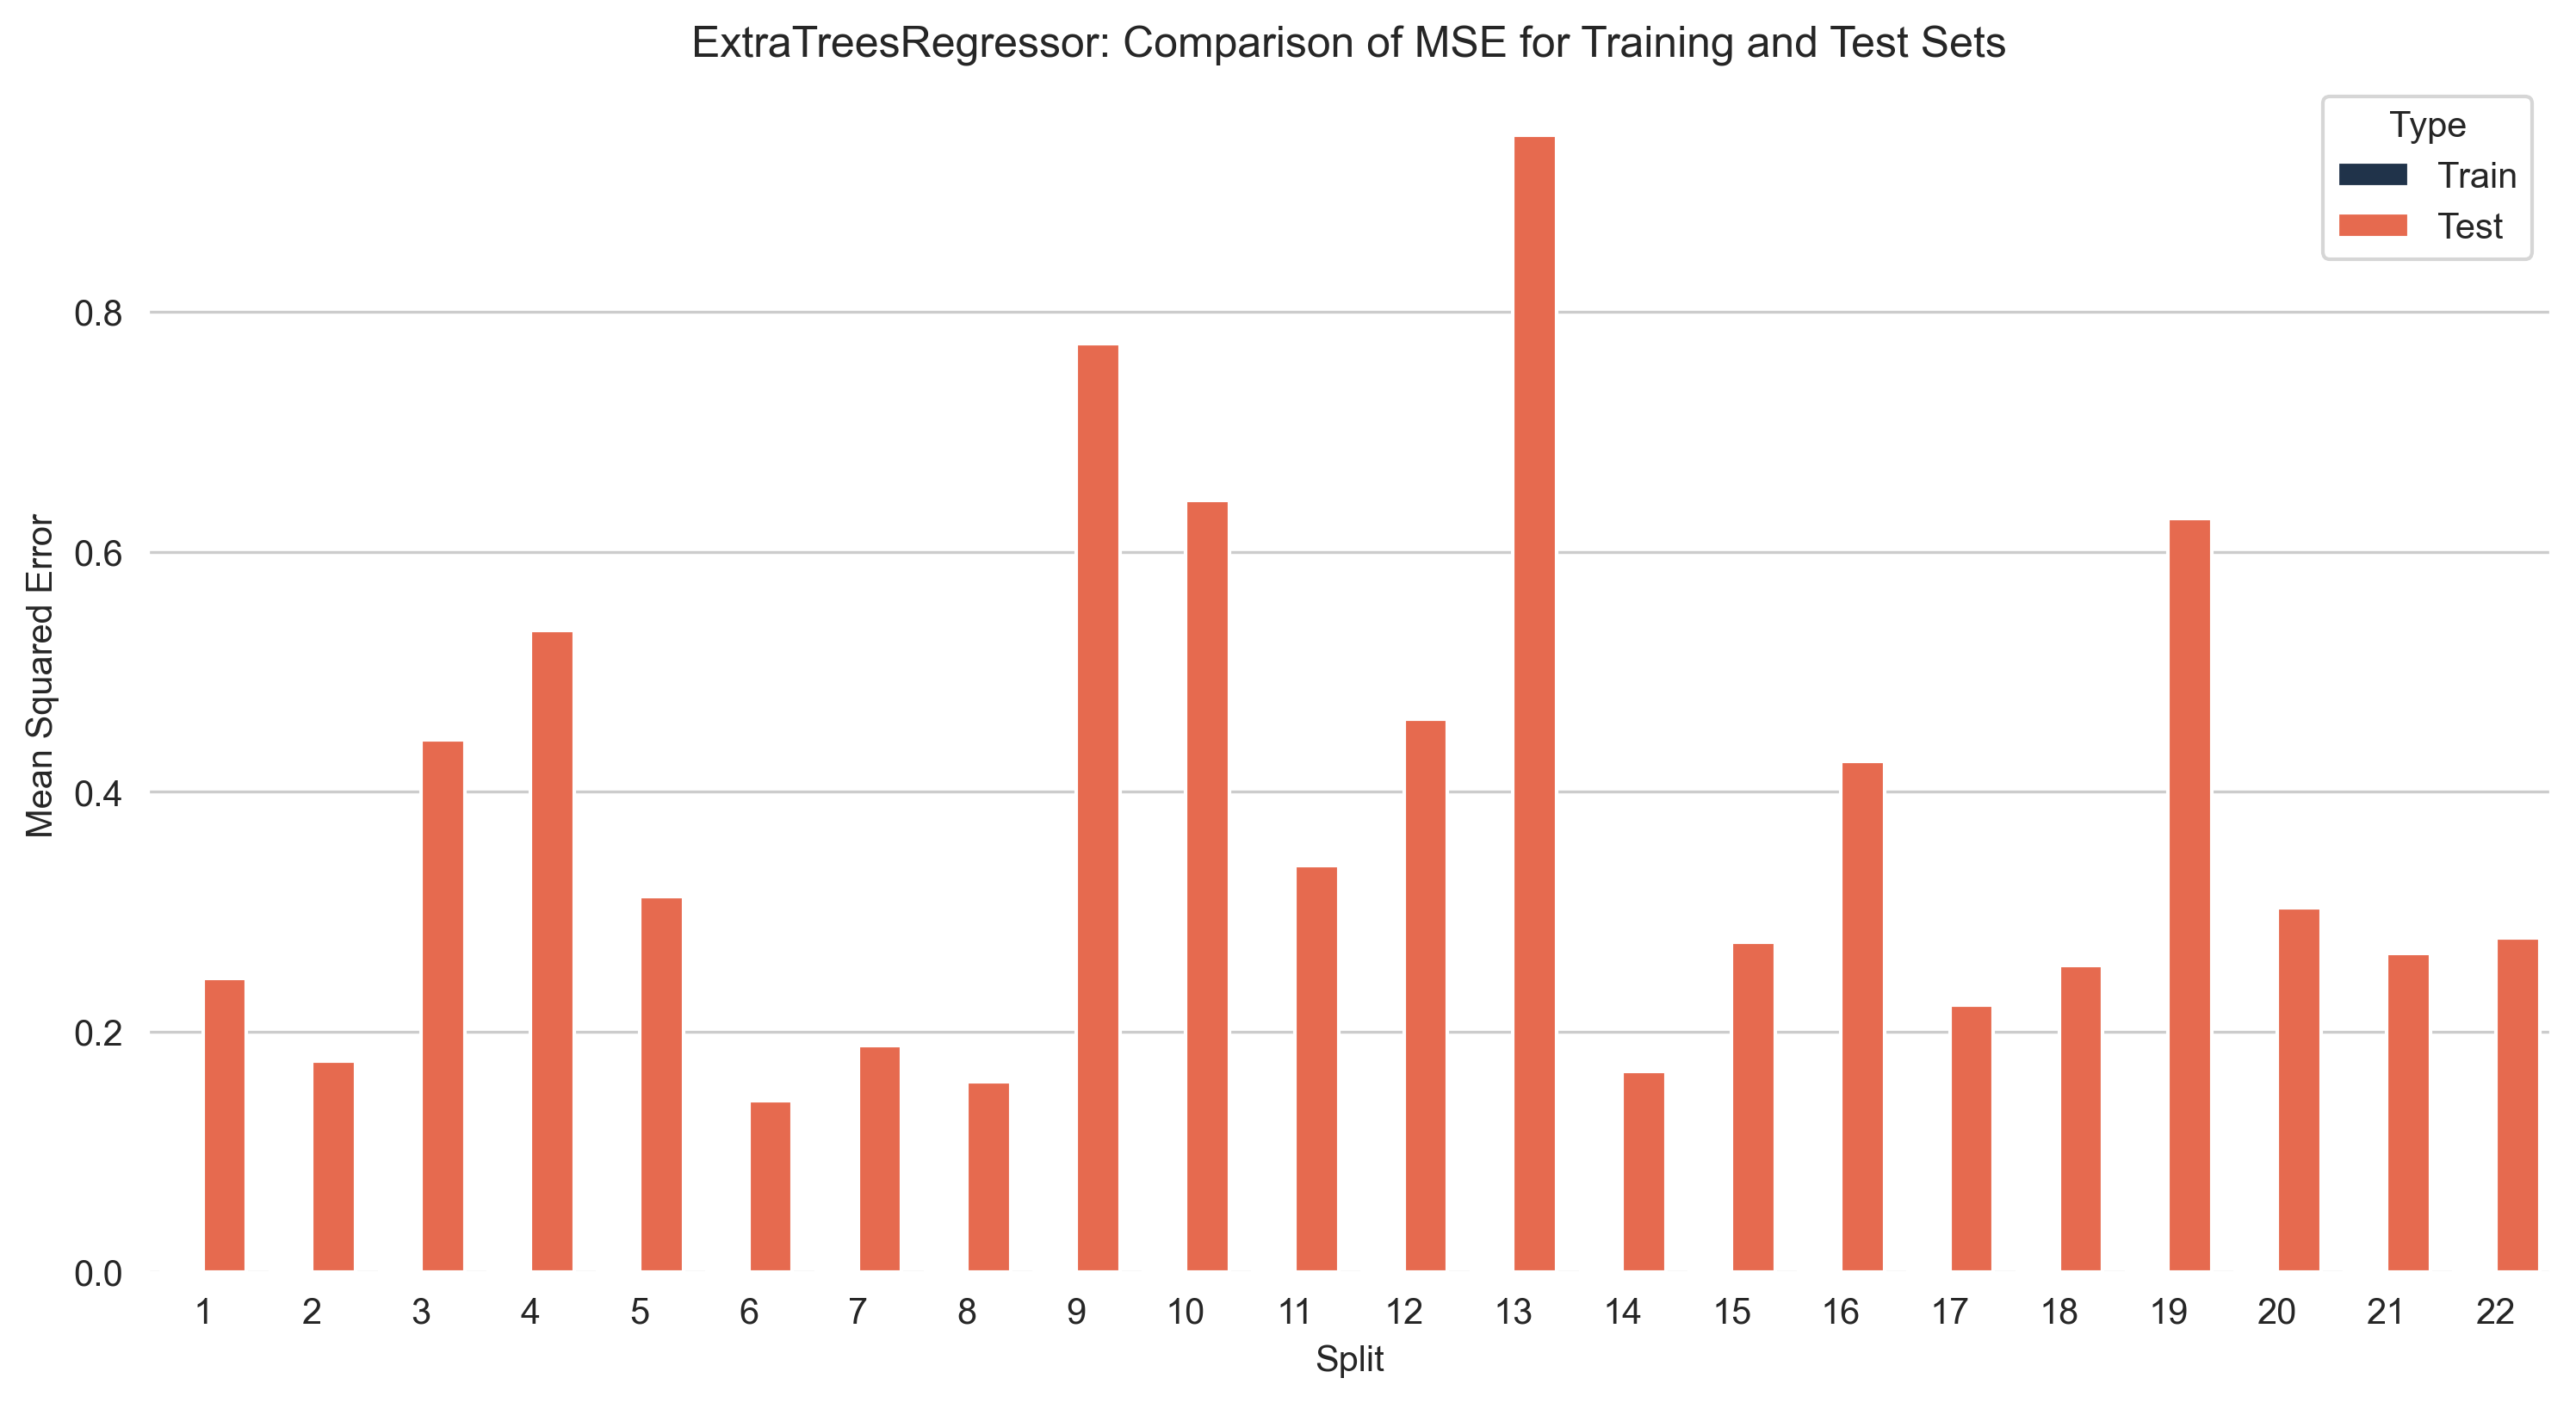

In [44]:
ETR_mse_scores, ETR_average_mse, ETR_mse_score_sum, ETR_plot_data = evaluate_time_series_model(X, y, ExtraTreesRegressor)
plot_time_series(ETR_plot_data, ETR_mse_score_sum, model_name='ExtraTreesRegressor')
z_rmse = np.sqrt(ETR_average_mse)
z_nor_mse = ETR_average_mse/np.var(y)
z_nor_std_rmse = z_rmse/np.std(y)
z_nor_ran_rmse = z_rmse/(np.max(y) - np.min(y))

In [45]:
# Use only the default features to predict the default price (for comparison)
X2 = df_modelling.drop(columns=['z_score', 'price_eur_mwh', 'rolling_mean_7d', 'rolling_std_7d', 'z_score_capped_5', 'z_score_na_5', 'z_score_na_3'])
y2 = df_modelling['price_eur_mwh']

Split 1:
MSE (train): 6.0114620657731226e-27, MSE (test): 38.48923256430557
Split 2:
MSE (train): 4.910198972943932e-27, MSE (test): 8.564687233472243
Split 3:
MSE (train): 4.253301979101774e-27, MSE (test): 7.001287726805545
Split 4:
MSE (train): 3.944051148288206e-27, MSE (test): 29.312345461388897
Split 5:
MSE (train): 3.738042581987886e-27, MSE (test): 36.178458026944426
Split 6:
MSE (train): 3.395361045537301e-27, MSE (test): 13.298603361944453
Split 7:
MSE (train): 3.090273627806717e-27, MSE (test): 33.51917473055554
Split 8:
MSE (train): 3.0931578481298183e-27, MSE (test): 18.491227713333345
Split 9:
MSE (train): 3.1362000151114188e-27, MSE (test): 376.59005347180596
Split 10:
MSE (train): 3.336543072192618e-27, MSE (test): 89.42647331166664
Split 11:
MSE (train): 3.879556830120525e-27, MSE (test): 92.49672205388946
Split 12:
MSE (train): 5.301762835114324e-27, MSE (test): 2649.462777929997
Split 13:
MSE (train): 1.0548531535344748e-26, MSE (test): 486.63635264444406
Split 14:
M

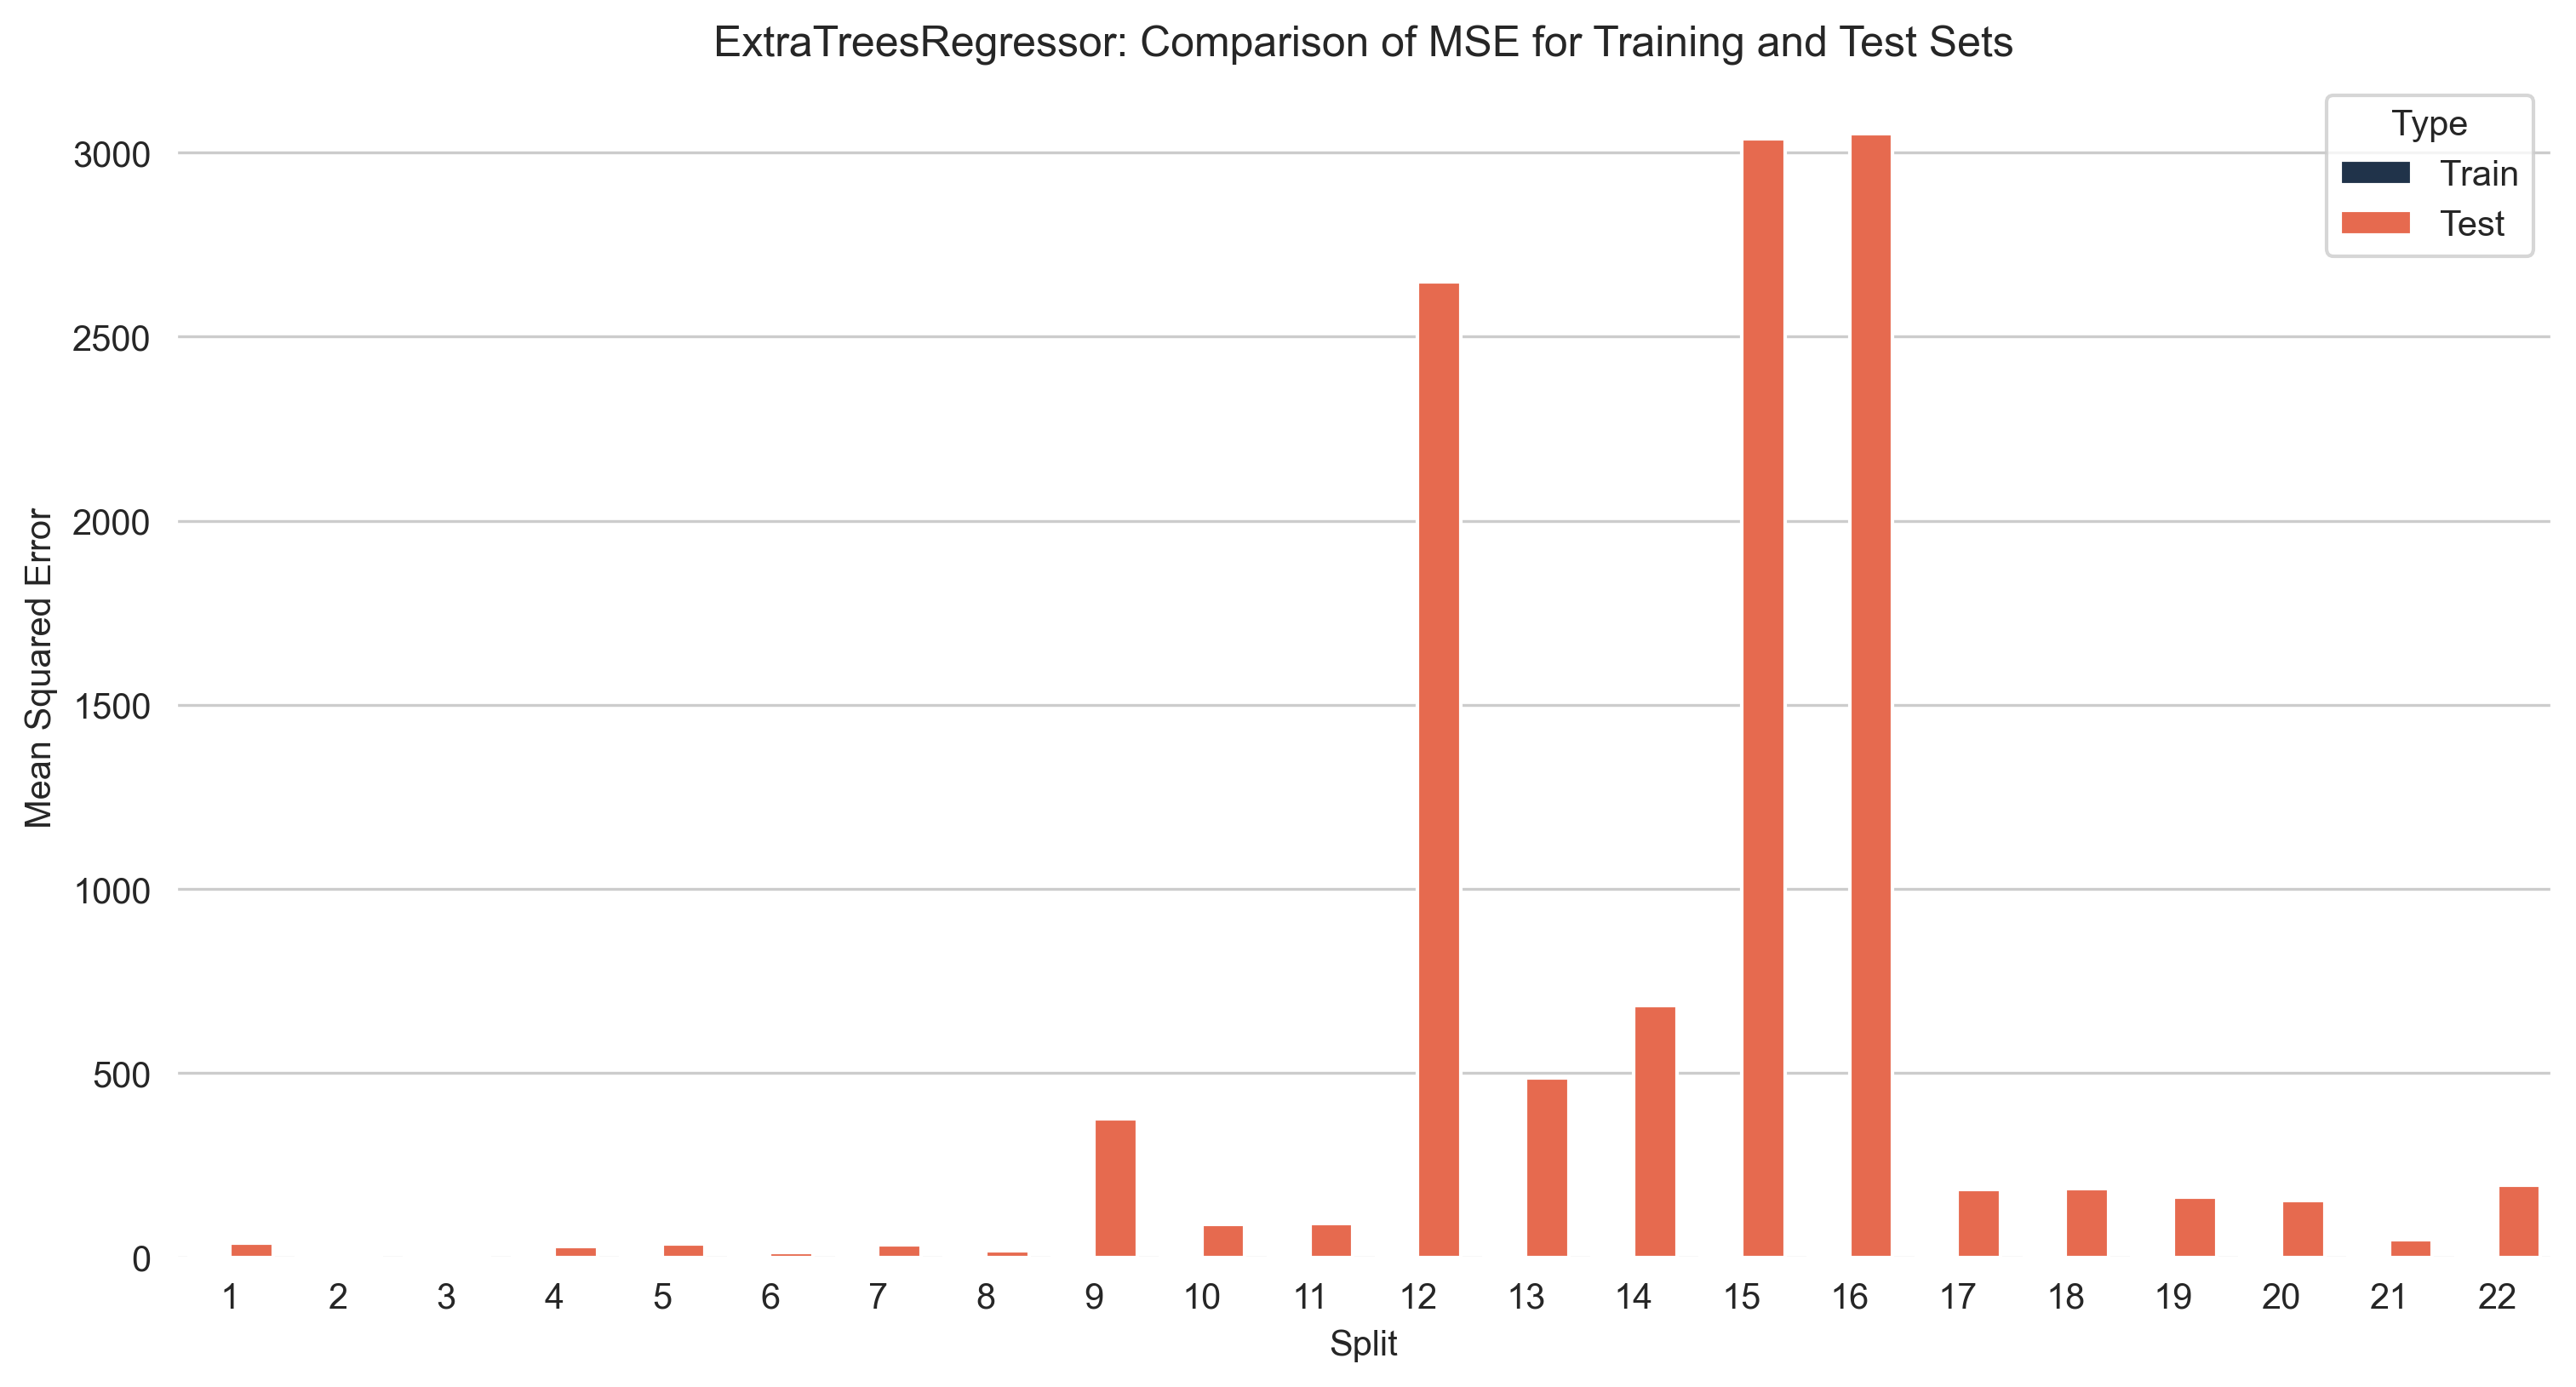

In [46]:
ETR_mse_scores, ETR_average_mse, ETR_mse_score_sum, ETR_plot_data = evaluate_time_series_model(X2, y2, ExtraTreesRegressor)
plot_time_series(ETR_plot_data, ETR_mse_score_sum, model_name='ExtraTreesRegressor', only_bar=True)
p_rmse = np.sqrt(ETR_average_mse)
p_nor_mse = ETR_average_mse/np.var(y)
p_nor_std_rmse = p_rmse/np.std(y)
p_nor_ran_rmse = p_rmse/(np.max(y) - np.min(y))

In [47]:
# Use the default features plus rolling mean and rolling variance to predict the default price
X3 = df_modelling.drop(columns=['z_score', 'price_eur_mwh', 'z_score_capped_5', 'z_score_na_5', 'z_score_na_3'])
y3 = df_modelling['price_eur_mwh']

Split 1:
MSE (train): 6.0114620657731226e-27, MSE (test): 40.208716722083345
Split 2:
MSE (train): 4.910198972943932e-27, MSE (test): 7.552214806944452
Split 3:
MSE (train): 4.253301979101774e-27, MSE (test): 6.411357629583355
Split 4:
MSE (train): 3.944051148288206e-27, MSE (test): 26.02580869569443
Split 5:
MSE (train): 3.738042581987886e-27, MSE (test): 38.45807475333333
Split 6:
MSE (train): 3.395361045537301e-27, MSE (test): 12.824938840555568
Split 7:
MSE (train): 3.090273627806717e-27, MSE (test): 44.21313748625002
Split 8:
MSE (train): 3.0931578481298183e-27, MSE (test): 18.74683054750001
Split 9:
MSE (train): 3.1362000151114188e-27, MSE (test): 335.808722106111
Split 10:
MSE (train): 3.336543072192618e-27, MSE (test): 106.70224045125009
Split 11:
MSE (train): 3.879556830120525e-27, MSE (test): 83.75573064305587
Split 12:
MSE (train): 5.301762835114324e-27, MSE (test): 2440.9813682251365
Split 13:
MSE (train): 1.0548531535344748e-26, MSE (test): 1028.559502660971
Split 14:
MSE 

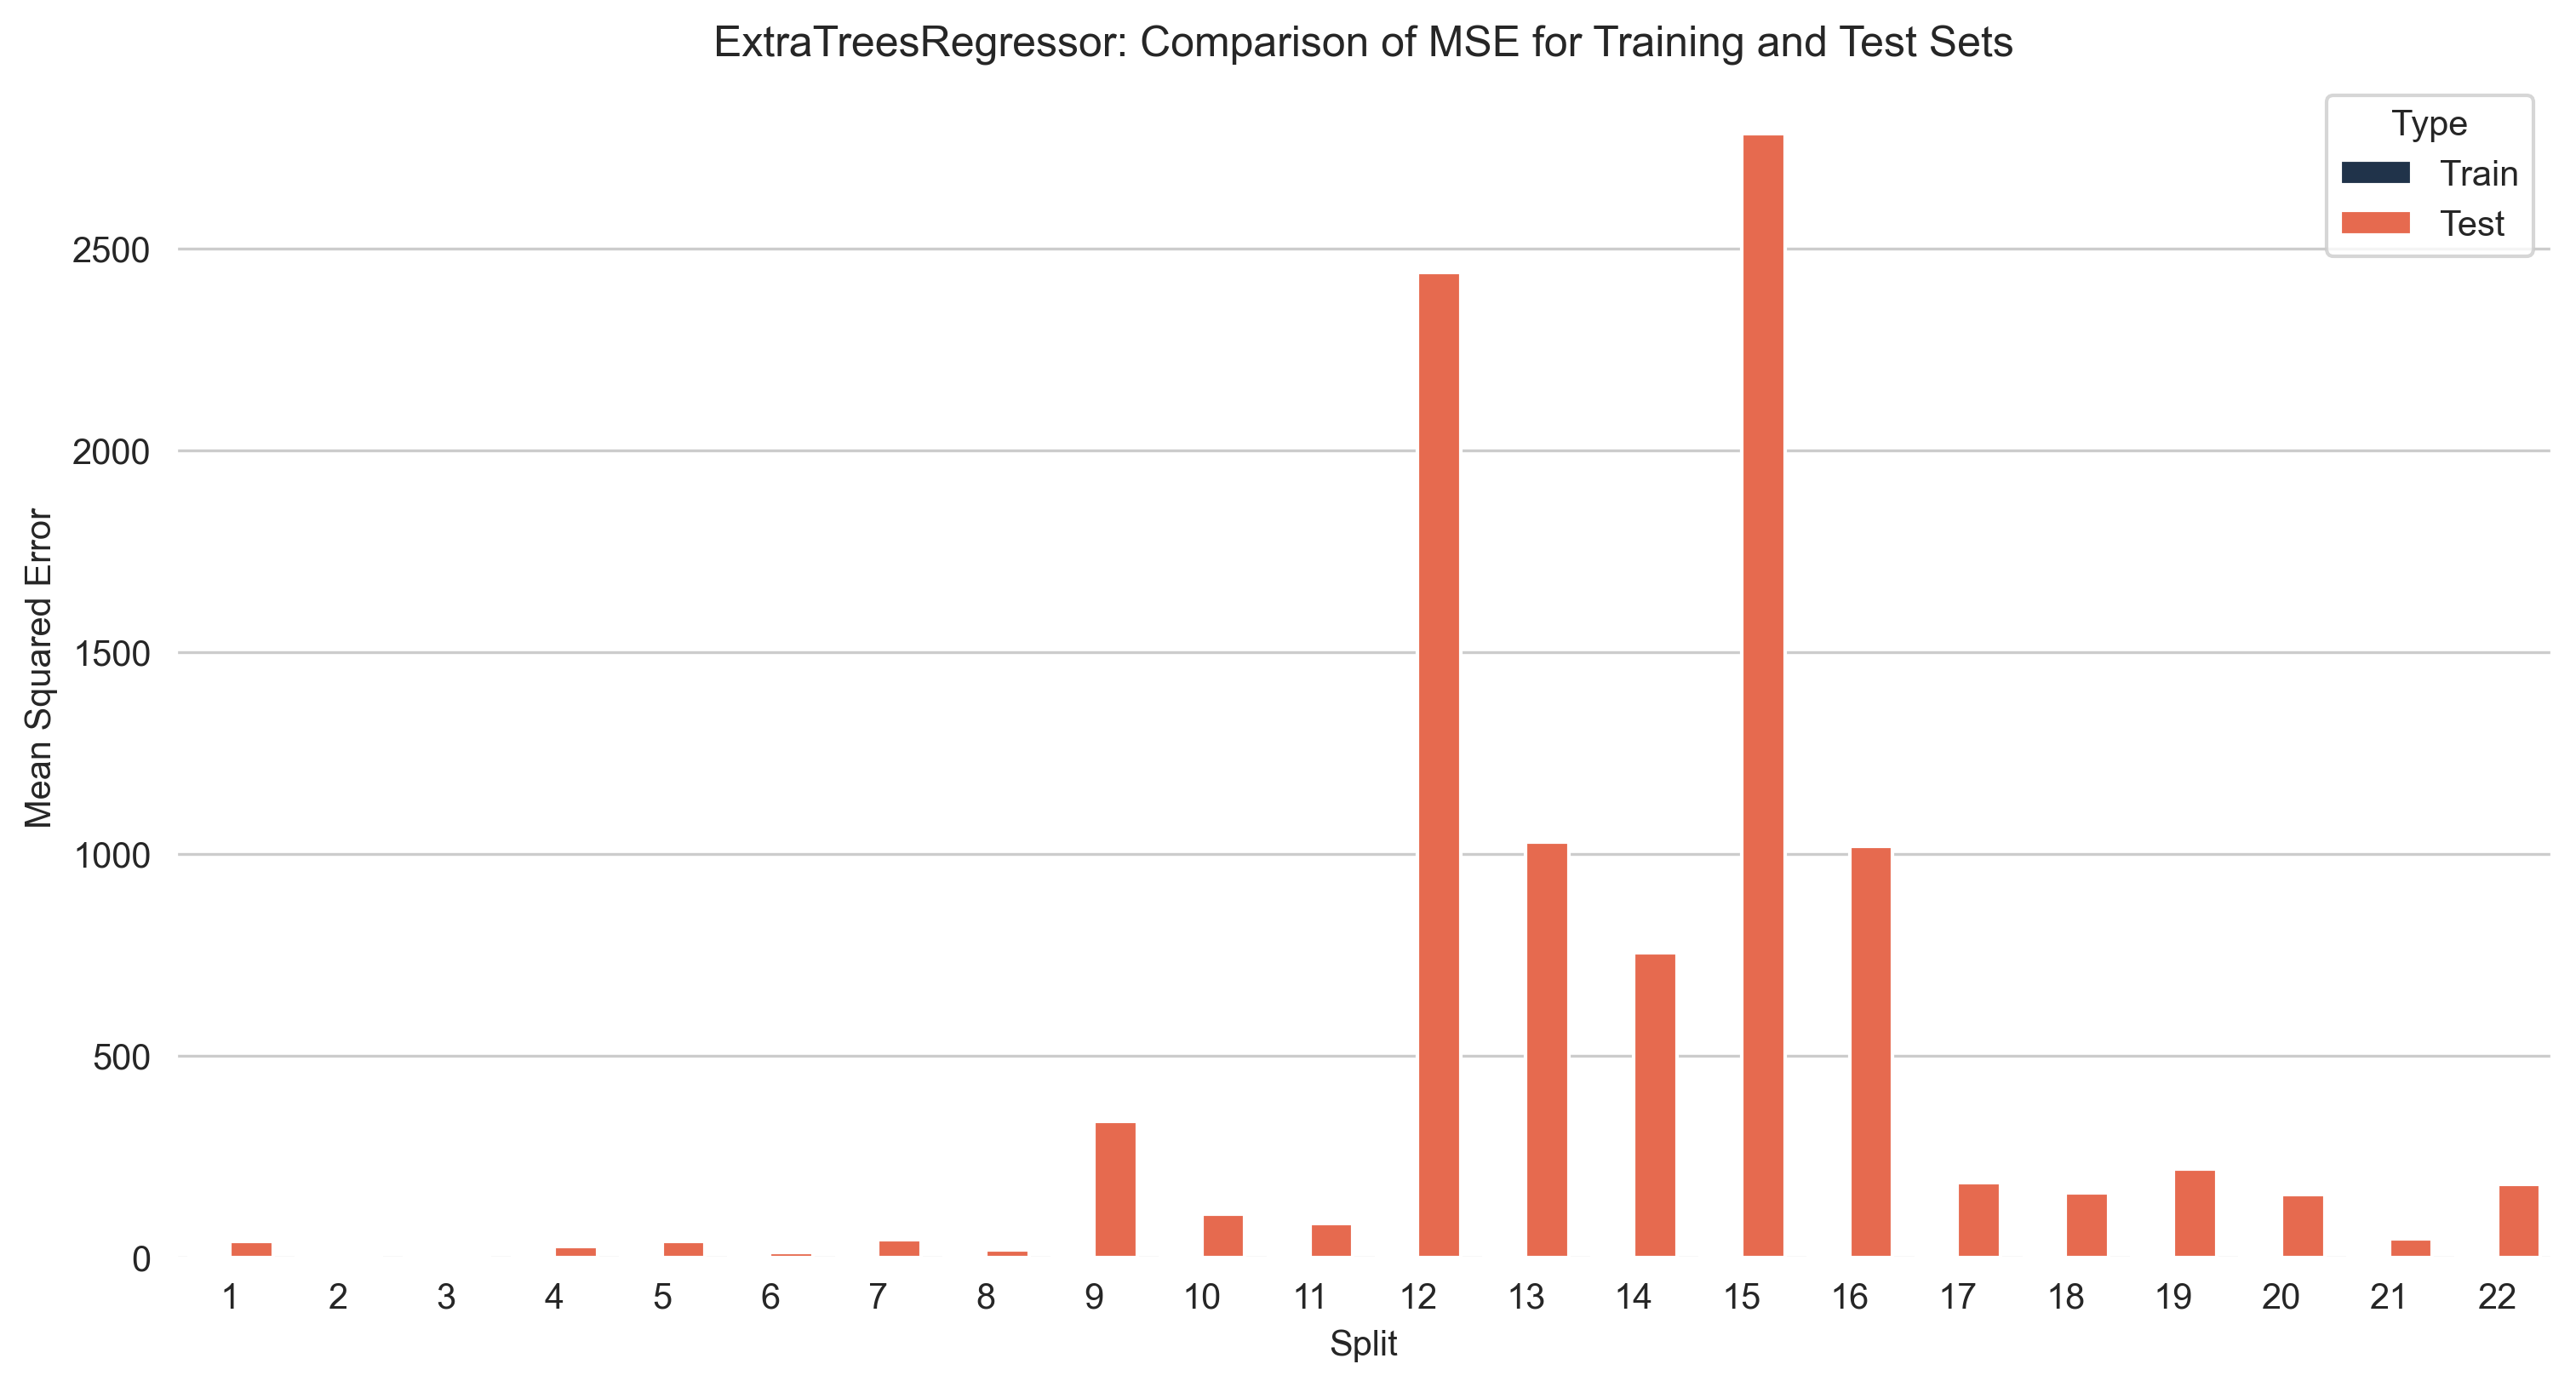

In [48]:
ETR_mse_scores, ETR_average_mse, ETR_mse_score_sum, ETR_plot_data = evaluate_time_series_model(X3, y3, ExtraTreesRegressor)
plot_time_series(ETR_plot_data, ETR_mse_score_sum, model_name='ExtraTreesRegressor', only_bar=True)
rp_rmse = np.sqrt(ETR_average_mse)
rp_nor_mse = ETR_average_mse/np.var(y)
rp_nor_std_rmse = rp_rmse/np.std(y)
rp_nor_ran_rmse = rp_rmse/(np.max(y) - np.min(y))

In [49]:
# RMSE
print(f"RMSE for target z-score: {z_rmse}")
print(f"RMSE for target price: {p_rmse}")
print(f"RMSE for target price with rolling mean and variance: {rp_rmse}")
print('---')
# RMSE
print(f"Normalized MSE for target z-score: {z_nor_mse}")
print(f"Normalized MSE for target price: {p_nor_mse}")
print(f"Normalized MSE for target price with rolling mean and variance: {rp_nor_mse}")
print('---')
# RMSE
print(f"RMSE standardized on standard deviation for target z-score: {z_nor_std_rmse}")
print(f"RMSE standardized on standard deviation for target price: {p_nor_std_rmse}")
print(f"RMSE standardized on standard deviation for target price with rolling mean and variance: {rp_nor_std_rmse}")
print('---')
# RMSE
print(f"RMSE standardized on range for target z-score: {z_nor_ran_rmse}")
print(f"RMSE standardized on range for target price: {p_nor_ran_rmse}")
print(f"RMSE standardized on range for target price with rolling mean and variance: {rp_nor_ran_rmse}")

RMSE for target z-score: 0.6097802722576617
RMSE for target price: 22.944046776521333
RMSE for target price with rolling mean and variance: 20.989442436873762
---
Normalized MSE for target z-score: 0.30371642348865424
Normalized MSE for target price: 429.9931886133316
Normalized MSE for target price with rolling mean and variance: 359.8515201188775
---
RMSE standardized on standard deviation for target z-score: 0.5511047300546915
RMSE standardized on standard deviation for target price: 20.736277115560828
RMSE standardized on standard deviation for target price with rolling mean and variance: 18.969752769049933
---
RMSE standardized on range for target z-score: 0.0384133109423197
RMSE standardized on range for target price: 1.4453678533063892
RMSE standardized on range for target price with rolling mean and variance: 1.3222369032182506
